In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [3]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# load data from grads notebook! 
def load_dataset(path="/n/home12/isanchez/jaxneuro/outputs/local_phys_dataset.npz"):
    d = np.load(path)
    out = {k: d[k] for k in d.files}
    for k in ("dt", "t_max", "i_delay", "i_dur", "N_trials", "Nsyn"):
        if k in out:
            out[k] = float(out[k]) if "." in str(out[k]) else int(out[k])
    return out

ds = load_dataset()

GRADS = ds["GRADS"]  # (N, Nsyn)
VLOCAL = ds["VLOCAL"]  # (N, Nsyn -1, T)
VSOMA = ds["VSOMA"]   # (N, T)
patterns = ds["patterns"] # (N, Nsyn)
losses = ds["losses"]  # (N,)
syn_post_comp_indices = ds["syn_post_comp_indices"]

dt = ds["dt"]
t_max = ds["t_max"]
i_delay = ds["i_delay"]
i_dur = ds["i_dur"]

N, Nsyn = GRADS.shape
T = VLOCAL.shape[2]
Nlocal = VLOCAL.shape[1]

# time axis
t = np.arange(T) * dt  # (T,)

# stimulus boolean mask
t_stim = (t >= i_delay) & (t <= i_delay + i_dur)


print(f"GRADS : {GRADS.shape}")
print(f"VLOCAL: {VLOCAL.shape}")
print(f"VSOMA : {VSOMA.shape}")
print(f"patterns:{patterns.shape}")
print(f"losses: {losses.shape}")
print(f"\n dt={dt} ms, t_max={t_max} ms,T={T} timepoints")
print(f"i_delay={i_delay} ms,i_dur={i_dur} ms")
print(f"stimulus window: {t_stim.sum()} timepoints "
      f"({t[t_stim][0]:.3f}–{t[t_stim][-1]:.3f} ms)")
print(f" N_trials={N},  Nsyn={Nsyn}")
print(f"syn_post_comp_indices = {syn_post_comp_indices}")

assert GRADS.shape == (N, Nsyn)
assert VLOCAL.shape == (N, Nsyn -1, T)
assert VSOMA.shape  == (N, T)
print("\nAll shape checks passed!!!")


GRADS : (500, 8)
VLOCAL: (500, 7, 2002)
VSOMA : (500, 2002)
patterns:(500, 8)
losses: (500,)

 dt=0.025 ms, t_max=50.0 ms,T=2002 timepoints
i_delay=3.0 ms,i_dur=2.0 ms
stimulus window: 81 timepoints (3.000–5.000 ms)
 N_trials=500,  Nsyn=8
syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]

All shape checks passed!!!


## Step 7a: time correlation map

At each timepoint t and for each synapse, we can compute the Pearson correlation (across trials n) between a local signal $x_{n,i}(t)$ and the scalar gradient $g_{n,i}$ so that we have 

$$r_i(t) = \text{corr}_n\!\big(x_{n,i}(t),\; g_{n,i}\big)$$

and then aggregate $\overline{r^2}(t) = \text{mean}_i\, r_i(t)^2$


Becuase I have v_soma and v_local, I can compute the correlation with the gradient of v_local. And separetly do v_soma? Or does it make more sense to do all at once? 

In [ ]:
def time_resolved_corr(signal, grads):
    N, Nsyn, T = signal.shape
    assert grads.shape == (N, Nsyn), f"Expected grads {(N, Nsyn)}, got {grads.shape}"

    r_by_syn = np.zeros((Nsyn, T))
    for i in range(Nsyn):
        g_i = grads[:, i] # in R^N
        # vectorised pearson r across all timepoints at once
        # signal[:, i, :] is (N, T) — correlate each column with g_i
        x = signal[:, i, :]  # in R^N
        # demean
        x_dm = x - x.mean(axis=0, keepdims=True)
        g_dm = g_i - g_i.mean()
        num = (x_dm * g_dm[:, None]).sum(axis=0)          # (T,)
        denom = np.sqrt((x_dm**2).sum(axis=0) * (g_dm**2).sum()) + 1e-30 # want to prevent division by zero 
        r_by_syn[i] = num / denom # (Nsyn, T)
    return r_by_syn


GRADS_local = GRADS[:, 1:] 
r_vlocal = time_resolved_corr(VLOCAL, GRADS_local) # (Nsyn-1, T)
mean_r2_vlocal = (r_vlocal**2).mean(axis=0)  # (T,)
mean_r_vlocal = r_vlocal.mean(axis=0) # (T,)


## look at changes in voltage? 
dVdt = np.gradient(VLOCAL, dt, axis=2)  # (N, Nsyn, T)
r_dvdt = time_resolved_corr(dVdt, GRADS_local)  # (Nsyn-1, T)
mean_r2_dvdt = (r_dvdt**2).mean(axis=0) # (T,)
mean_r_dvdt = r_dvdt.mean(axis=0) # (T,)

print(f"r_vlocal shape: {r_vlocal.shape}")
print(f"mean_r2_vlocal shape: {mean_r2_vlocal.shape}")
print(f"r_dvdt shape: {r_dvdt.shape}")
print(f"mean_r2_dvdt shape: {mean_r2_dvdt.shape}")


r_vlocal shape: (7, 2002)
mean_r2_vlocal shape: (2002,)
r_dvdt shape: (7, 2002)
mean_r2_dvdt shape: (2002,)


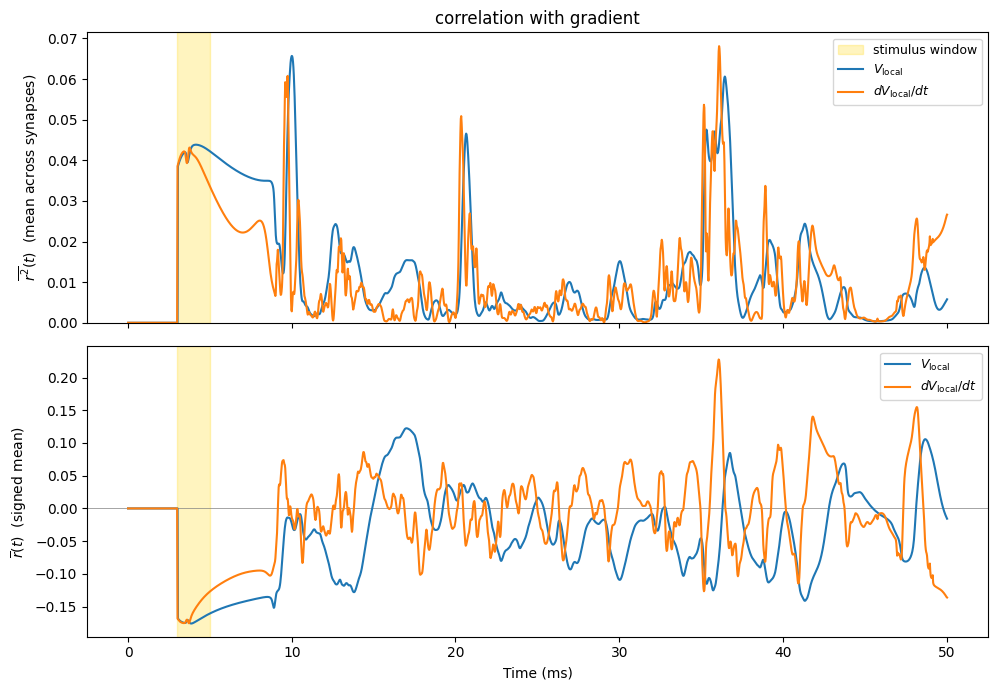

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus window")
ax.plot(t, mean_r2_vlocal, label=r"$V_{\rm local}$", lw=1.5)
ax.plot(t, mean_r2_dvdt,   label=r"$dV_{\rm local}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r^2}(t)$  (mean across synapses)")
ax.set_title("correlation with gradient")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
ax.axhline(0, color="grey", lw=0.5)
ax.plot(t, mean_r_vlocal, label=r"$V_{\rm local}$", lw=1.5)
ax.plot(t, mean_r_dvdt,   label=r"$dV_{\rm local}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r}(t)$  (signed mean)")
ax.set_xlabel("Time (ms)")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


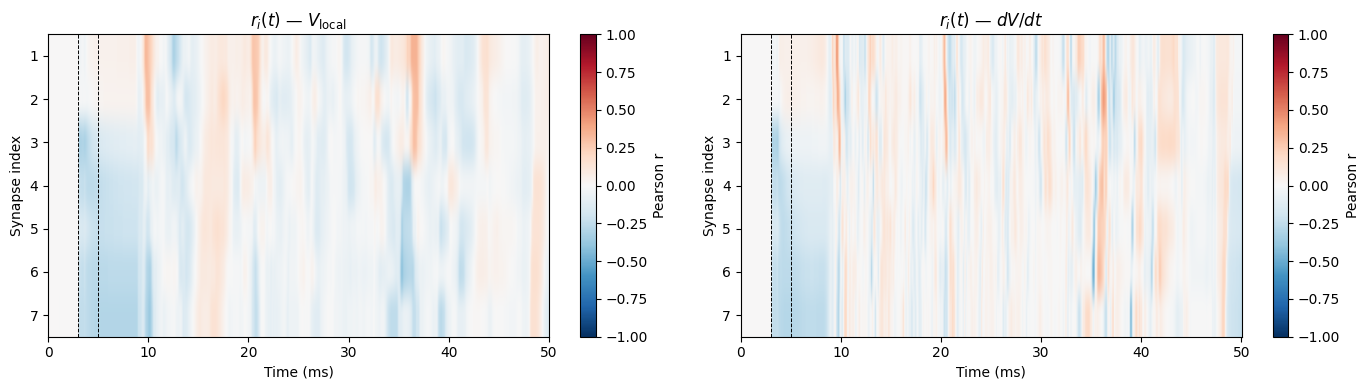

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

syn_start = 1                      # because VLOCAL corresponds to syn 1..Nsyn-1
Ns = r_vlocal.shape[0]             # == Nsyn-1
syn_end = syn_start + Ns - 1       # == Nsyn-1

for ax, data, title in zip(
    axes,
    [r_vlocal, r_dvdt],
    [r"$r_i(t)$ — $V_{\rm local}$", r"$r_i(t)$ — $dV/dt$"],
):
    im = ax.imshow(
        data,
        aspect="auto",
        cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], syn_end + 0.5, syn_start - 0.5],  # <-- updated
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label="Pearson r")

plt.tight_layout()
plt.show()

In [ ]:
save_A = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "analysis_stepA.npz")
np.savez(
    save_A,
    r_vlocal=r_vlocal,          # (Nsyn, T)
    mean_r2_vlocal=mean_r2_vlocal,  # (T,)
    mean_r_vlocal=mean_r_vlocal,
    r_dvdt=r_dvdt,
    mean_r2_dvdt=mean_r2_dvdt,
    mean_r_dvdt=mean_r_dvdt,
    t=t,
)
print(f"✓ Step A saved → {save_A}  ({os.path.getsize(save_A)/1e3:.1f} kB)")


✓ Step A saved → /n/home12/isanchez/jaxneuro/outputs/analysis_stepA.npz  (338.1 kB)


So far just seems to be the case that the strongest possible predictive time is really early like near stimulus onset(or like the initial polarization)

also seems to be something happening later on, but not sure how to quantify? maybe more spiking/bAP? 


synapse specific credits vs global effect? I wonder if this is where you do off vs on diagonals? how to zone inmore to bap times etc

## Step B — Baseline hand-picked window features

### B1 — Feature extraction

For each trial $n$ and synapse $i$ we compute a small bank of interpretable features from fixed time windows (stimulus window, post-spike window).


In [72]:
# ===================================================================
# Deliverable B1 — Feature extraction for a small feature bank
# ===================================================================

# # Compute dV/dt here so this cell is self-contained
# # (also computed in Step A, but we don't require that cell to run first)
# dVdt = np.gradient(VLOCAL, dt, axis=2)   # (N, Nsyn, T)

# -------------------------------------------------------------------
# 1. Stimulus-window features  (computed from VLOCAL and dVdt)
# -------------------------------------------------------------------
stim_mask = t_stim  # boolean (T,)

# Slices of the signals inside the stimulus window
V_stim  = VLOCAL[:, :, stim_mask]          # (N, Nsyn, T_stim)
dV_stim = dVdt[:, :, stim_mask]            # (N, Nsyn, T_stim)

mean_V_stim   = V_stim.mean(axis=2)       # (N, Nsyn)
peak_V_stim   = V_stim.max(axis=2)        # (N, Nsyn)
auc_V_stim    = V_stim.sum(axis=2) * dt   # (N, Nsyn) — integral approximation
max_dVdt_stim = dV_stim.max(axis=2)       # (N, Nsyn)
min_dVdt_stim = dV_stim.min(axis=2)       # (N, Nsyn)

print(f"Stimulus window: {stim_mask.sum()} timepoints, "
      f"V_stim shape {V_stim.shape}")

# -------------------------------------------------------------------
# 2. bAP-proxy / spike-locked features
# -------------------------------------------------------------------
# Detect soma spike times via threshold crossing on VSOMA
spike_threshold = 0.0  # mV  (generous for HH spikes that peak ~+40 mV)
bap_window_ms   = 3.0  # ms after soma spike to look for local peak
bap_window_pts  = int(bap_window_ms / dt)

def detect_spikes(v_soma, threshold=0.0):
    """Return indices of upward threshold crossings."""
    above = v_soma > threshold
    crossings = np.where(np.diff(above.astype(int)) == 1)[0]
    return crossings  # indices into time axis

# For each trial, detect spike times and extract bAP features
bap_peak_local  = np.full((N, Nsyn), np.nan)   # max V in post-spike window
bap_amp_local   = np.full((N, Nsyn), np.nan)   # peak − pre-spike baseline

for n in range(N):
    spk_idx = detect_spikes(VSOMA[n], spike_threshold)
    if len(spk_idx) == 0:
        continue
    # Use only the FIRST spike (simplest proxy)
    s0 = spk_idx[0]
    s1 = min(s0 + bap_window_pts, T)
    # Baseline: mean V in 1 ms before spike
    bl_start = max(0, s0 - int(1.0 / dt))
    for i in range(Nsyn):
        v_win = VLOCAL[n, i, s0:s1]
        if len(v_win) == 0:
            continue
        pk = v_win.max()
        bl = VLOCAL[n, i, bl_start:s0].mean() if s0 > bl_start else VLOCAL[n, i, 0]
        bap_peak_local[n, i] = pk
        bap_amp_local[n, i]  = pk - bl

n_spikes_detected = np.sum(~np.isnan(bap_peak_local[:, 0]))
print(f"Trials with ≥1 soma spike: {n_spikes_detected}/{N}")

# Explicit indicator: did this trial have a spike?  (broadcast to all synapses)
spiked = (~np.isnan(bap_peak_local[:, 0])).astype(float)[:, None]  # (N, 1)
spiked = np.repeat(spiked, Nsyn, axis=1)                           # (N, Nsyn)

# -------------------------------------------------------------------
# 3. Assemble feature matrix  X (N*Nsyn, n_features), y (N*Nsyn,)
# -------------------------------------------------------------------
feature_dict = {
    "mean_V_stim":    mean_V_stim,       # (N, Nsyn)
    "peak_V_stim":    peak_V_stim,
    "auc_V_stim":     auc_V_stim,
    "max_dVdt_stim":  max_dVdt_stim,
    "min_dVdt_stim":  min_dVdt_stim,
    "bap_peak_local": bap_peak_local,
    "bap_amp_local":  bap_amp_local,
    "spiked":         spiked,            # binary indicator — spike present
}

feature_names = list(feature_dict.keys())
n_features = len(feature_names)

# Stack into (N, Nsyn, n_features) then reshape
feature_stack = np.stack([feature_dict[fn] for fn in feature_names], axis=-1)  # (N, Nsyn, F)
X_raw = feature_stack.reshape(N * Nsyn, n_features)                            # (N*Nsyn, F)
y = GRADS.reshape(-1)                                                          # (N*Nsyn,)

# Handle NaNs from trials without spikes: impute with column median
from numpy import nanmedian
for col in range(n_features):
    mask_nan = np.isnan(X_raw[:, col])
    if mask_nan.any():
        X_raw[mask_nan, col] = nanmedian(X_raw[:, col])

X = X_raw.copy()

print(f"\nFeature matrix X shape: {X.shape}  (N*Nsyn, n_features)")
print(f"Target vector  y shape: {y.shape}")
print(f"Features: {feature_names}")

# Save
save_B1 = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "features_baseline.npz")
np.savez(
    save_B1,
    X=X, y=y,
    feature_names=np.array(feature_names),
    N=N, Nsyn=Nsyn,
    stim_mask=stim_mask,
    bap_window_ms=bap_window_ms,
    spike_threshold=spike_threshold,
)
print(f"✓ Saved → {save_B1}  ({os.path.getsize(save_B1)/1e3:.1f} kB)")


Stimulus window: 81 timepoints, V_stim shape (500, 8, 81)
Trials with ≥1 soma spike: 413/500

Feature matrix X shape: (4000, 8)  (N*Nsyn, n_features)
Target vector  y shape: (4000,)
Features: ['mean_V_stim', 'peak_V_stim', 'auc_V_stim', 'max_dVdt_stim', 'min_dVdt_stim', 'bap_peak_local', 'bap_amp_local', 'spiked']
✓ Saved → /n/home12/isanchez/jaxneuro/outputs/features_baseline.npz  (292.5 kB)


### B2 — Baseline predictive performance (CV)

We use **trial-split** cross-validation: folds split by trial index so that all synapses from one trial are either in train or test (never mixed). This prevents information leakage via shared trial-level confounds.

- **Ridge regression** → predict gradient magnitude → report CV $R^2$ and Pearson $r$
- **Logistic regression** → predict sign of gradient → report accuracy and AUROC


In [73]:
# ===================================================================
# Deliverable B2 — Baseline predictive performance (CV)
# ===================================================================
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import (r2_score, roc_auc_score, accuracy_score,
                             balanced_accuracy_score)
from scipy.stats import pearsonr

n_folds = 5
n_inner_folds = 3   # for hyperparameter selection inside each outer fold

# Trial-level group labels: row k in X corresponds to trial k // Nsyn
trial_ids = np.repeat(np.arange(N), Nsyn)  # (N*Nsyn,)

gkf = GroupKFold(n_splits=n_folds)

# ---- Containers for fold-level metrics ----
ridge_r2_folds      = []
ridge_r_folds       = []
logistic_acc_folds  = []
logistic_bacc_folds = []   # balanced accuracy
logistic_auc_folds  = []
majority_acc_folds  = []   # majority-class baseline

# For one example fold we'll store predictions for plotting
best_fold_y_true = None
best_fold_y_pred = None

for fold_i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=trial_ids)):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # Standardise features (fit on train only)
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # ---- Ridge regression (gradient magnitude) ----
    # Inner CV respects trial groups to avoid leakage
    inner_groups_tr = trial_ids[train_idx]
    ridge_gs = GridSearchCV(
        Ridge(),
        {"alpha": np.logspace(-2, 6, 50)},
        cv=GroupKFold(n_splits=n_inner_folds),
        scoring="r2",
    )
    ridge_gs.fit(X_tr_s, y_tr, groups=inner_groups_tr)
    y_pred_ridge = ridge_gs.predict(X_te_s)

    r2    = r2_score(y_te, y_pred_ridge)
    r_val = pearsonr(y_te, y_pred_ridge)[0]
    ridge_r2_folds.append(r2)
    ridge_r_folds.append(r_val)

    # Save first fold for plotting
    if fold_i == 0:
        best_fold_y_true = y_te
        best_fold_y_pred = y_pred_ridge

    # ---- Logistic regression (sign of gradient) ----
    y_sign_tr = (y_tr > 0).astype(int)
    y_sign_te = (y_te > 0).astype(int)

    # Majority-class baseline
    majority_class_frac = max(y_sign_te.mean(), 1 - y_sign_te.mean())
    majority_acc_folds.append(majority_class_frac)

    # Check there are both classes
    if len(np.unique(y_sign_tr)) > 1 and len(np.unique(y_sign_te)) > 1:
        logit_gs = GridSearchCV(
            LogisticRegression(max_iter=2000),
            {"C": np.logspace(-3, 3, 20)},
            cv=GroupKFold(n_splits=n_inner_folds),
            scoring="roc_auc",
        )
        logit_gs.fit(X_tr_s, y_sign_tr, groups=inner_groups_tr)
        y_prob = logit_gs.predict_proba(X_te_s)[:, 1]
        y_pred_sign = logit_gs.predict(X_te_s)
        acc  = accuracy_score(y_sign_te, y_pred_sign)
        bacc = balanced_accuracy_score(y_sign_te, y_pred_sign)
        auc  = roc_auc_score(y_sign_te, y_prob)
        logistic_acc_folds.append(acc)
        logistic_bacc_folds.append(bacc)
        logistic_auc_folds.append(auc)
    else:
        logistic_acc_folds.append(np.nan)
        logistic_bacc_folds.append(np.nan)
        logistic_auc_folds.append(np.nan)

    print(f"  Fold {fold_i}: Ridge R²={r2:.4f} r={r_val:.4f} | "
          f"Logistic bal_acc={logistic_bacc_folds[-1]:.4f} AUC={logistic_auc_folds[-1]:.4f} "
          f"(majority baseline acc={majority_class_frac:.4f})")

# ---- Summary ----
print("\n" + "=" * 70)
print("BASELINE METRICS  (mean +/- std across folds)")
print("=" * 70)
print(f"  Ridge R²            : {np.mean(ridge_r2_folds):.4f} +/- {np.std(ridge_r2_folds):.4f}")
print(f"  Ridge Pearson r     : {np.mean(ridge_r_folds):.4f} +/- {np.std(ridge_r_folds):.4f}")
print(f"  Logistic acc        : {np.nanmean(logistic_acc_folds):.4f} +/- {np.nanstd(logistic_acc_folds):.4f}")
print(f"  Logistic bal. acc   : {np.nanmean(logistic_bacc_folds):.4f} +/- {np.nanstd(logistic_bacc_folds):.4f}")
print(f"  Logistic AUROC      : {np.nanmean(logistic_auc_folds):.4f} +/- {np.nanstd(logistic_auc_folds):.4f}")
print(f"  Majority-class acc  : {np.mean(majority_acc_folds):.4f}  (dumb baseline)")

# Save metrics
baseline_metrics = {
    "ridge_r2_mean":  float(np.mean(ridge_r2_folds)),
    "ridge_r2_std":   float(np.std(ridge_r2_folds)),
    "ridge_r_mean":   float(np.mean(ridge_r_folds)),
    "ridge_r_std":    float(np.std(ridge_r_folds)),
    "logistic_acc_mean":  float(np.nanmean(logistic_acc_folds)),
    "logistic_acc_std":   float(np.nanstd(logistic_acc_folds)),
    "logistic_bacc_mean": float(np.nanmean(logistic_bacc_folds)),
    "logistic_bacc_std":  float(np.nanstd(logistic_bacc_folds)),
    "logistic_auc_mean":  float(np.nanmean(logistic_auc_folds)),
    "logistic_auc_std":   float(np.nanstd(logistic_auc_folds)),
    "majority_acc_mean":  float(np.mean(majority_acc_folds)),
    "n_folds": n_folds,
    "n_inner_folds": n_inner_folds,
    "feature_names": feature_names,
    "ridge_r2_folds":      [float(v) for v in ridge_r2_folds],
    "ridge_r_folds":       [float(v) for v in ridge_r_folds],
    "logistic_acc_folds":  [float(v) for v in logistic_acc_folds],
    "logistic_bacc_folds": [float(v) for v in logistic_bacc_folds],
    "logistic_auc_folds":  [float(v) for v in logistic_auc_folds],
    "majority_acc_folds":  [float(v) for v in majority_acc_folds],
}
metrics_path = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "baseline_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(baseline_metrics, f, indent=2)
print(f"\n✓ Metrics saved → {metrics_path}")


  Fold 0: Ridge R²=0.0343 r=0.1896 | Logistic bal_acc=0.6491 AUC=0.7151 (majority baseline acc=0.6375)
  Fold 1: Ridge R²=0.0187 r=0.1667 | Logistic bal_acc=0.6356 AUC=0.7186 (majority baseline acc=0.6050)
  Fold 2: Ridge R²=-0.0145 r=0.0798 | Logistic bal_acc=0.6203 AUC=0.6740 (majority baseline acc=0.6462)
  Fold 3: Ridge R²=0.0175 r=0.1483 | Logistic bal_acc=0.6296 AUC=0.6470 (majority baseline acc=0.6088)
  Fold 4: Ridge R²=0.0931 r=0.3716 | Logistic bal_acc=0.6347 AUC=0.7448 (majority baseline acc=0.5800)

BASELINE METRICS  (mean +/- std across folds)
  Ridge R²            : 0.0298 +/- 0.0354
  Ridge Pearson r     : 0.1912 +/- 0.0974
  Logistic acc        : 0.6755 +/- 0.0049
  Logistic bal. acc   : 0.6339 +/- 0.0093
  Logistic AUROC      : 0.6999 +/- 0.0348
  Majority-class acc  : 0.6155  (dumb baseline)

✓ Metrics saved → /n/home12/isanchez/jaxneuro/outputs/baseline_metrics.json


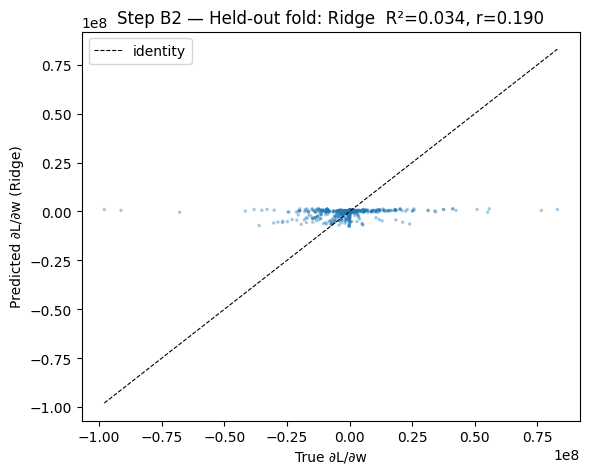

In [74]:
# ---- Plot: predicted vs true gradient on held-out fold ----
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(best_fold_y_true, best_fold_y_pred, s=6, alpha=0.4, edgecolors="none")
lims = [min(best_fold_y_true.min(), best_fold_y_pred.min()),
        max(best_fold_y_true.max(), best_fold_y_pred.max())]
ax.plot(lims, lims, "k--", lw=0.8, label="identity")
ax.set_xlabel("True ∂L/∂w")
ax.set_ylabel("Predicted ∂L/∂w (Ridge)")
ax.set_title(f"Step B2 — Held-out fold: Ridge  R²={ridge_r2_folds[0]:.3f}, r={ridge_r_folds[0]:.3f}")
ax.legend()
plt.tight_layout()
plt.show()


## Step C — Cross-validated kernel/window search

### C1 — Gaussian kernel search

Instead of hand-picking a window, define a Gaussian kernel and optimise (c, sigma) via grid search with cross-validation.


In [76]:
# ===================================================================
# Deliverable C1 — Gaussian kernel search implementation
# ===================================================================

def gaussian_kernel(t, center, sigma):
    """Normalised Gaussian kernel over time axis t."""
    k = np.exp(-0.5 * ((t - center) / sigma) ** 2)
    k /= k.sum() + 1e-30   # normalise so weights sum to 1
    return k  # (T,)

def kernel_summary(signal, t, center, sigma):
    """
    Compute scalar summary mu_{n,i} = sum_t k(t) * x_{n,i}(t).

    signal : (N, Nsyn, T)
    Returns: (N, Nsyn)
    """
    k = gaussian_kernel(t, center, sigma)  # (T,)
    return np.einsum("nit,t->ni", signal, k)

def corr_sq_over_trials(mu, grads, eps=1e-12):
    """
    Vectorised, NaN-safe squared Pearson r for each synapse.

    mu, grads : (N, Nsyn)
    Returns   : (Nsyn,)  — r^2 per synapse; 0 where input is (near-)constant.
    """
    mu_dm = mu - mu.mean(axis=0, keepdims=True)
    g_dm  = grads - grads.mean(axis=0, keepdims=True)

    num = (mu_dm * g_dm).sum(axis=0)                        # (Nsyn,)
    den = np.sqrt((mu_dm**2).sum(axis=0) * (g_dm**2).sum(axis=0)) + eps

    r  = num / den
    r2 = r ** 2

    # If mu or grads are (near-)constant, den ~ eps → treat as no signal
    bad = (den <= 10 * eps)
    r2[bad] = 0.0
    return r2

def kernel_objective(signal, grads, t, center, sigma, trial_idx=None):
    """
    J(c, sigma) = mean_i corr_n(mu_{n,i}, g_{n,i})^2
    evaluated on the trials indicated by trial_idx (index array).
    """
    mu = kernel_summary(signal, t, center, sigma)  # (N, Nsyn)
    if trial_idx is not None:
        mu = mu[trial_idx]
        g  = grads[trial_idx]
    else:
        g = grads
    r2_vals = corr_sq_over_trials(mu, g)  # (Nsyn,)
    return r2_vals.mean()

# -------------------------------------------------------------------
# Baseline-subtract signals so kernels read event-related changes,
# not resting-potential offsets
# -------------------------------------------------------------------
pre_stim_mask = t < i_delay   # everything before stimulus onset

VLOCAL_bs = VLOCAL - VLOCAL[:, :, pre_stim_mask].mean(axis=2, keepdims=True)
dVdt_bs   = dVdt   - dVdt[:, :, pre_stim_mask].mean(axis=2, keepdims=True)

print(f"Baseline-subtracted VLOCAL_bs: {VLOCAL_bs.shape}")
print(f"Baseline-subtracted dVdt_bs:   {dVdt_bs.shape}")

# -------------------------------------------------------------------
# Grid definition — focused on informative time range
# -------------------------------------------------------------------
# c_lo = max(0, i_delay - 2.0)
# c_hi = i_delay + i_dur + 10.0
# centers = np.linspace(c_lo, c_hi, 80)
# sigmas  = np.logspace(np.log10(max(2 * dt, 0.05)), np.log10(15.0), 40)
c_lo2 = max(0, i_delay - 5.0)
c_hi2 = i_delay + i_dur + 10.0
centers = np.linspace(c_lo2, c_hi2, 100)
sigmas  = np.logspace(np.log10(max(2 * dt, 0.05)), np.log10(15.0), 40)

print(f"\nGrid: {len(centers)} centers x {len(sigmas)} sigmas = {len(centers)*len(sigmas)} evaluations")
print(f"Center range: {centers[0]:.2f}–{centers[-1]:.2f} ms")
print(f"Sigma range:  {sigmas[0]:.3f}–{sigmas[-1]:.2f} ms")


Baseline-subtracted VLOCAL_bs: (500, 8, 2002)
Baseline-subtracted dVdt_bs:   (500, 8, 2002)

Grid: 100 centers x 40 sigmas = 4000 evaluations
Center range: 0.00–15.00 ms
Sigma range:  0.050–15.00 ms


In [77]:
# -------------------------------------------------------------------
# Run grid search with K-fold CV (trial-split)
# -------------------------------------------------------------------
def kernel_grid_search(signal, grads, t, centers, sigmas, n_folds=5, signal_name="signal"):
    """
    Grid search over (center, sigma) with GroupKFold CV.

    Returns
    -------
    J_train : (n_centers, n_sigmas)  mean train J across folds
    J_val   : (n_centers, n_sigmas)  mean val J across folds
    best_center, best_sigma, best_J_val : best params on validation
    """
    N_total = signal.shape[0]
    trial_ids_local = np.arange(N_total)
    gkf_local = GroupKFold(n_splits=n_folds)

    nc, ns = len(centers), len(sigmas)
    J_val_accum   = np.zeros((nc, ns))
    J_train_accum = np.zeros((nc, ns))

    # Pre-compute fold index arrays (faster than boolean masks)
    folds = list(gkf_local.split(np.arange(N_total), groups=trial_ids_local))

    print(f"Kernel grid search for '{signal_name}' ({nc}x{ns} grid, {n_folds} folds) ...")

    for ci, c in enumerate(centers):
        for si, s in enumerate(sigmas):
            fold_val_scores  = []
            fold_train_scores = []
            for train_idx, val_idx in folds:
                j_train = kernel_objective(signal, grads, t, c, s, trial_idx=train_idx)
                j_val   = kernel_objective(signal, grads, t, c, s, trial_idx=val_idx)
                fold_train_scores.append(j_train)
                fold_val_scores.append(j_val)
            J_train_accum[ci, si] = np.mean(fold_train_scores)
            J_val_accum[ci, si]   = np.mean(fold_val_scores)

        if (ci + 1) % 20 == 0 or ci == nc - 1:
            print(f"  ... {ci+1}/{nc} centers done")

    # Best on validation — NaN-safe: treat NaN as -inf
    J_val_safe = np.nan_to_num(J_val_accum, nan=-np.inf)
    best_idx = np.unravel_index(np.argmax(J_val_safe), J_val_safe.shape)
    best_c = centers[best_idx[0]]
    best_s = sigmas[best_idx[1]]
    best_J = J_val_accum[best_idx]

    n_nan = np.isnan(J_val_accum).sum()
    if n_nan > 0:
        print(f"  (note: {n_nan}/{nc*ns} grid cells were NaN — ignored)")
    print(f"  Best (c*, sigma*) = ({best_c:.2f} ms, {best_s:.3f} ms)  J_val = {best_J:.4f}")
    return J_train_accum, J_val_accum, best_c, best_s, best_J


In [78]:
# ---- Run for V_local (baseline-subtracted) ----
J_train_vl, J_val_vl, best_c_vl, best_s_vl, best_J_vl = kernel_grid_search(
    VLOCAL_bs, GRADS, t, centers, sigmas, n_folds=5, signal_name="V_local (bs)"
)


Kernel grid search for 'V_local (bs)' (100x40 grid, 5 folds) ...
  ... 20/100 centers done
  ... 40/100 centers done
  ... 60/100 centers done
  ... 80/100 centers done
  ... 100/100 centers done
  Best (c*, sigma*) = (10.00 ms, 0.050 ms)  J_val = 0.0531


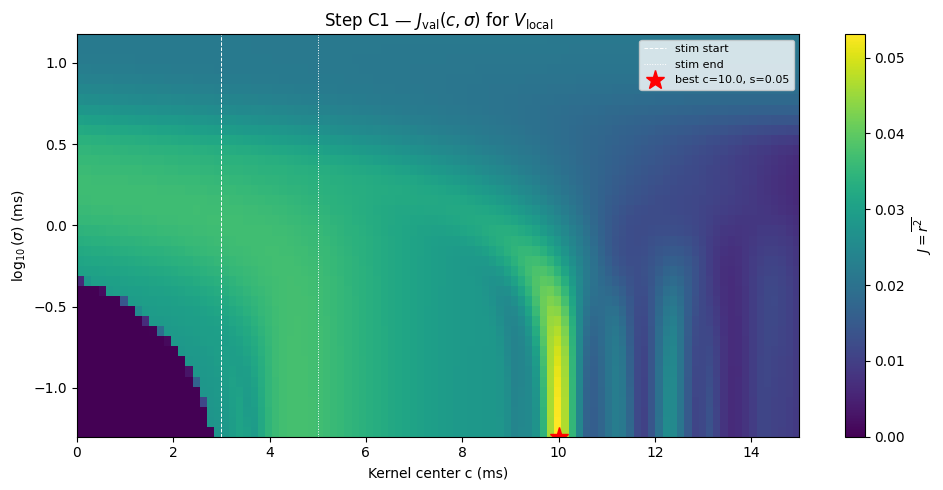

In [79]:
# ---- Heatmap for V_local ----
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
im = ax.imshow(
    J_val_vl.T, origin="lower", aspect="auto",
    extent=[centers[0], centers[-1], np.log10(sigmas[0]), np.log10(sigmas[-1])],
    cmap="viridis",
)
ax.axvline(i_delay, color="white", ls="--", lw=0.7, label="stim start")
ax.axvline(i_delay + i_dur, color="white", ls=":", lw=0.7, label="stim end")
ax.plot(best_c_vl, np.log10(best_s_vl), "r*", ms=14, label=f"best c={best_c_vl:.1f}, s={best_s_vl:.2f}")
ax.set_xlabel("Kernel center c (ms)")
ax.set_ylabel(r"$\log_{10}(\sigma)$ (ms)")
ax.set_title(r"Step C1 — $J_{\rm val}(c,\sigma)$ for $V_{\rm local}$")
plt.colorbar(im, ax=ax, label=r"$J = \overline{r^2}$")
ax.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()


### C2 - Repeat kernel search across signals and compare


In [ ]:
# ---- Run for dV/dt (baseline-subtracted) ----
J_train_dv, J_val_dv, best_c_dv, best_s_dv, best_J_dv = kernel_grid_search(
    dVdt_bs, GRADS, t, centers, sigmas, n_folds=5, signal_name="dV/dt (bs)"
)


NameError: name 'kernel_grid_search' is not defined

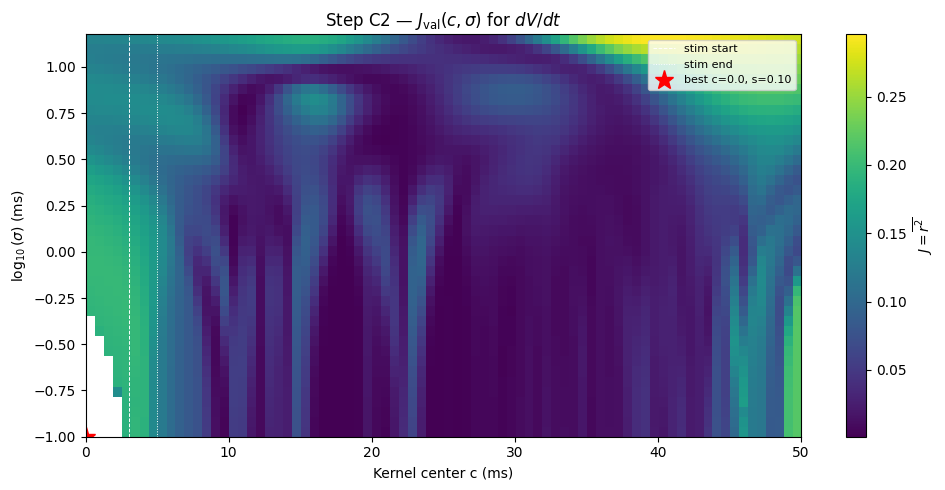

In [ ]:
# ---- Heatmap for dV/dt ----
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
im = ax.imshow(
    J_val_dv.T, origin="lower", aspect="auto",
    extent=[centers[0], centers[-1], np.log10(sigmas[0]), np.log10(sigmas[-1])],
    cmap="viridis",
)
ax.axvline(i_delay, color="white", ls="--", lw=0.7, label="stim start")
ax.axvline(i_delay + i_dur, color="white", ls=":", lw=0.7, label="stim end")
ax.plot(best_c_dv, np.log10(best_s_dv), "r*", ms=14, label=f"best c={best_c_dv:.1f}, s={best_s_dv:.2f}")
ax.set_xlabel("Kernel center c (ms)")
ax.set_ylabel(r"$\log_{10}(\sigma)$ (ms)")
ax.set_title(r"Step C2 — $J_{\rm val}(c,\sigma)$ for $dV/dt$")
plt.colorbar(im, ax=ax, label=r"$J = \overline{r^2}$")
ax.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Comparison table ----
print("=" * 70)
print("KERNEL SEARCH RESULTS — Best (c*, sigma*) per signal")
print("=" * 70)
print(f"{'Signal':<15} {'c* (ms)':>10} {'sigma* (ms)':>12} {'J_val':>10}")
print("-" * 70)
print(f"{'V_local':<15} {best_c_vl:>10.2f} {best_s_vl:>12.3f} {best_J_vl:>10.4f}")
print(f"{'dV/dt':<15} {best_c_dv:>10.2f} {best_s_dv:>12.3f} {best_J_dv:>10.4f}")
print("-" * 70)
winner = "V_local" if best_J_vl >= best_J_dv else "dV/dt"
print(f"Best signal: {winner}")


KERNEL SEARCH RESULTS — Best (c*, sigma*) per signal
Signal             c* (ms)  sigma* (ms)      J_val
----------------------------------------------------------------------
V_local               0.00        0.100        nan
dV/dt                 0.00        0.100        nan
----------------------------------------------------------------------
Best signal: dV/dt


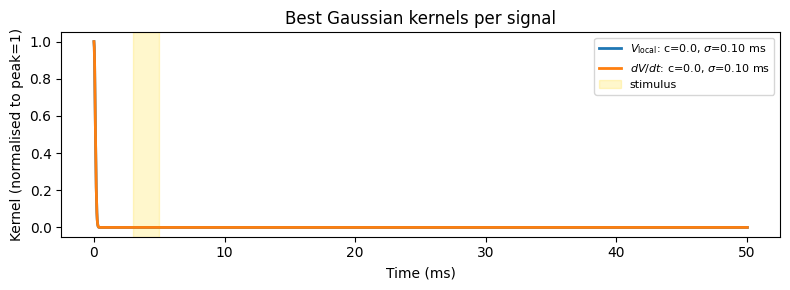

In [ ]:
# ---- Plot best kernels overlaid on time axis ----
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
k_vl = gaussian_kernel(t, best_c_vl, best_s_vl)
k_dv = gaussian_kernel(t, best_c_dv, best_s_dv)
ax.plot(t, k_vl / k_vl.max(), label=rf"$V_{{\rm local}}$: c={best_c_vl:.1f}, $\sigma$={best_s_vl:.2f} ms", lw=2)
ax.plot(t, k_dv / k_dv.max(), label=rf"$dV/dt$: c={best_c_dv:.1f}, $\sigma$={best_s_dv:.2f} ms", lw=2)
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stimulus")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Kernel (normalised to peak=1)")
ax.set_title("Best Gaussian kernels per signal")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Save kernel search results ----
save_C = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "kernel_search_results.npz")
np.savez(
    save_C,
    # Grid
    centers=centers,
    sigmas=sigmas,
    # V_local
    J_train_vlocal=J_train_vl,
    J_val_vlocal=J_val_vl,
    best_center_vlocal=best_c_vl,
    best_sigma_vlocal=best_s_vl,
    best_J_val_vlocal=best_J_vl,
    # dVdt
    J_train_dvdt=J_train_dv,
    J_val_dvdt=J_val_dv,
    best_center_dvdt=best_c_dv,
    best_sigma_dvdt=best_s_dv,
    best_J_val_dvdt=best_J_dv,
)
print(f"Saved  {save_C}  ({os.path.getsize(save_C)/1e3:.1f} kB)")


## Analysis Summary

**Saved outputs:**

| File | Contents |
|------|----------|
| `analysis_stepA.npz` | Per-synapse r(t) arrays + mean r^2(t) for V_local and dV/dt |
| `features_baseline.npz` | Feature matrix X, target y, feature names |
| `baseline_metrics.json` | CV Ridge R^2, Pearson r, Logistic accuracy, AUROC |
| `kernel_search_results.npz` | Full J(c,sigma) grids + best params for V_local and dV/dt |
